<a href="https://colab.research.google.com/github/aecoaker/FTA-Summary/blob/master/Exploring_BART_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring BART Models to find best Pre-Trained Option

## Example of work prediction

In [3]:
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig
import statistics
import time
import copy
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# load a pre-trained model and tokenizer 'bart-large-cnn'
tokeniser = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [ ]:
text = "'customs duty reduction or elimination' means any customs duty reduction or elimination"

In [ ]:
#use bart for summary of the sentence to check it all works
inputs = tokeniser.batch_encode_plus([text],return_tensors='pt')
summary_ids = model.generate(inputs['input_ids'], early_stopping=True)
bart_summaries = tokeniser.decode(summary_ids[0], skip_special_tokens=True)
print(bart_summaries)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'customs duty reduction or elimination' means any customs duty collection or elimination


In [ ]:
#create text with a masked word
text = "'customs duty reduction or elimination' means any customs duty <mask> or elimination"

In [ ]:
#now use BART to predict what the word is
input_ids = tokeniser([text], return_tensors="pt")["input_ids"]
logits = model(input_ids).logits
masked_index = (input_ids[0] == tokeniser.mask_token_id).nonzero().item()
probs = logits[0, masked_index].softmax(dim=0)
values, predictions = probs.topk(5) #only get top 5 predictions
tokeniser.decode(predictions).split()

['reduction', 'reductions', 'cut', 'increase', 'reduced']

## Writing this into a function that generates a metric

In [ ]:
def perplexity(text, model = 'facebook/bart-base'):
  #read in chosen model and set up empty lists to use
  tokeniser = BartTokenizer.from_pretrained(model)
  model = BartForConditionalGeneration.from_pretrained(model)
  prod__pp_t = 1
  calculated_probs = []
  #tokenise text to get its length
  input_ids = tokeniser([text], return_tensors="pt")["input_ids"]
  n = len(input_ids[0])
  #iterate through tokens
  for i in range(1, n):
    #get full set of inputs, find real value then replace token with '<mask>'
    input_ids = tokeniser([text], return_tensors="pt")["input_ids"]
    true_token = int(input_ids[0][i])
    input_ids[0][i] = 50264
    #find sliding window of tokens to use as context
    if n < 1024:
      window_start = 0
      window_end = n
    else:
      window_start = i - 512
      window_end = i + 512
    if window_start < 0:
      window_start = 0
      window_end += -(i - 512)
    if window_end > n:
      window_end = n
      window_start += -(n - i - 512)
    #subset the input_ids to only look at the sliding window
    input_ids = input_ids[:, window_start:window_end]
    #use BART to predict what this token is given the context in the window
    logits = model(input_ids).logits
    masked_index = (input_ids[0] == tokeniser.mask_token_id).nonzero().item()
    probs = logits[0, masked_index].softmax(dim=0)
    values, predictions = probs.topk(1000)
    #get the probability of the true token within this prediction
    try:
      true_token_index = predictions.tolist().index(true_token)
      true_token_prob = values[true_token_index].detach().numpy().item()
    #deal with words that aren't in the top 1000 predictions by assigning them a very small probability
    except:
      true_token_prob = 0.00000000001
    #calculate the reciprocals of the probabilities and multiple together
    calculated_probs.append(true_token_prob)
    pp_t = 1/true_token_prob
    prod__pp_t *= pp_t
  #calculate the perplexity by normalising this, also (for comparison) show avg probabilities
  perplexity = prod__pp_t ** (1/n)
  print(perplexity)
  print(statistics.mean(calculated_probs))

In [ ]:
text = "After receipt by a Party's investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. "
start = time.perf_counter()
perplexity(text)
end = time.perf_counter()

15.062052423780026
0.3582747515974616


In [ ]:
print('The text had ' + str(len(text.split())) + ' words and this took ' + str(end - start) + ' seconds to run')

The text had 51 words and this took 15.918545544999972 seconds to run


Therefore for the full FTA (over 100,000 words), it would take more than 8 hours to calculate the perplexity (longer when you consider that tokenising a full 1024 token sliding window to get the context will take longer than doing so for 51 words).

In [ ]:
#re-writing function to sample a window from the text (not a sliding window)
#we will use that instead of the full text in order to allow us to measure for FTAs
def perplexity(text, model = 'facebook/bart-base'):
  #read in chosen model and set up empty lists to use
  tokeniser = BartTokenizer.from_pretrained(model)
  model = BartForConditionalGeneration.from_pretrained(model)
  prod__pp_t = 1
  all_probs = []
  #tokenise text to get its length
  input_ids = tokeniser([text], return_tensors="pt")["input_ids"]
  n = len(input_ids[0])
  #randomly select a window in which we will consider the perplexity
  m = 600
  if n > m:
    window_start = random.sample(range(0, n - m), 1)[0]
    window_end = window_start + m
  else:
    window_start = 0
    window_end = n
  #get tokens for this window only
  input_ids = input_ids[:, window_start:window_end]
  #iterate through tokens in this window only
  for i in range(0, window_end - window_start):
    #find real value then replace its token with '<mask>'
    input_ids_to_mask = copy.deepcopy(input_ids) #copy tokens instead of re-generating each loop
    true_token = int(input_ids_to_mask[0][i])
    input_ids_to_mask[0][i] = 50264
    #use BART to predict what this token is given the context in the window
    logits = model(input_ids_to_mask).logits
    masked_index = (input_ids_to_mask[0] == tokeniser.mask_token_id).nonzero().item()
    probs = logits[0, masked_index].softmax(dim=0)
    values, predictions = probs.topk(1000)
    #get the probability of the true token within this prediction
    try:
      true_token_index = predictions.tolist().index(true_token)
      true_token_prob = values[true_token_index].detach().numpy().item()
    #deal with words that aren't in the top 1000 predictions by assigning them a very small probability
    except:
      true_token_prob = 0.00001
    #calculate the reciprocals of the probabilities and multiple together
    all_probs.append(true_token_prob)
    pp_t = 1.0/true_token_prob
    prod__pp_t *= pp_t
  #calculate the perplexity by normalising this, also (for comparison) show avg probabilities
  perplexity = prod__pp_t ** (1.0/(window_end - window_start))
  print('The perplexity of this model applies to the text was ' + str(perplexity))
  print('This came from an average probability of the masked token being: ' + str(statistics.mean(all_probs)))

In [ ]:
#check this still works as expected for smaller blocks of text
text = "After receipt by a Party's investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. "
perplexity(text)

The perplexity of this model applies to the text was 15.062052955338832
This came from an average probability of the masked token being: 0.3686250351319093


In [ ]:
#test on a large block of text
text = 'For the purposes of this Chapter: “bilateral safeguard measure” means a measure referred to in paragraph 2 of Article 3.6 (Application of a Bilateral Safeguard Measure); “customs duty reduction or elimination” means any customs duty reduction or elimination in accordance with paragraph 2 of Article 2.5 (Treatment of Customs Duties – Trade in Goods); “domestic industry” means, with respect to an imported good, the producers as a whole of the like or directly competitive good operating within the territory of a Party, or those whose collective output of the like or directly competitive good constitutes a major proportion of the total domestic production of the good; “serious injury” means a significant overall impairment in the position of a domestic industry; “threat of serious injury” means serious injury that is clearly imminent, in accordance with the provisions of Article 3.8 (Investigation Procedure). A determination of the existence of a threat of serious injury shall be based on facts and not merely on allegation, conjecture, or remote possibility; and “transition period” means, in relation to a good, the entry into force of this Agreement until five years after the completion of the customs duty reduction or elimination in relation to the good. After receipt by a Party’s investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. 2. Without prejudice to its other rights and obligations under the SCM Agreement, prior to initiating a countervailing duty investigation against imports from the other Party, the importing Party shall afford to the other Party a reasonable opportunity to consult with the aim of clarifying the situation on matters raised in the application and arriving at a mutually agreed solution. Any such consultations shall not unnecessarily delay or prevent a Party from proceeding expeditiously to initiate and conduct an investigation. 3. The Parties reaffirm their rights and obligations under Articles 6.2 and 6.3 of the AD Agreement and Article 12.2 of the SCM Agreement, including with respect to the rights of interested parties to present information orally and to defend their interests in the conduct of an anti-dumping investigation or a countervailing duty investigation. 4. Each Party shall ensure, before a final determination is made, full and meaningful disclosure of all essential facts under consideration which form the basis for the decision whether to apply definitive measures in an anti-dumping investigation or a countervailing duty investigation. This is without prejudice to Article 6.5 of the AD Agreement and Article 12.4 of the SCM Agreement. Disclosures shall be made in writing, and allow interested parties sufficient time to defend their interests. For the purposes of this Chapter: “bilateral safeguard measure” means a measure referred to in paragraph 2 of Article 3.6 (Application of a Bilateral Safeguard Measure); “customs duty reduction or elimination” means any customs duty reduction or elimination in accordance with paragraph 2 of Article 2.5 (Treatment of Customs Duties – Trade in Goods); “domestic industry” means, with respect to an imported good, the producers as a whole of the like or directly competitive good operating within the territory of a Party, or those whose collective output of the like or directly competitive good constitutes a major proportion of the total domestic production of the good; “serious injury” means a significant overall impairment in the position of a domestic industry; “threat of serious injury” means serious injury that is clearly imminent, in accordance with the provisions of Article 3.8 (Investigation Procedure). A determination of the existence of a threat of serious injury shall be based on facts and not merely on allegation, conjecture, or remote possibility; and “transition period” means, in relation to a good, the entry into force of this Agreement until five years after the completion of the customs duty reduction or elimination in relation to the good. After receipt by a Party’s investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. 2. Without prejudice to its other rights and obligations under the SCM Agreement, prior to initiating a countervailing duty investigation against imports from the other Party, the importing Party shall afford to the other Party a reasonable opportunity to consult with the aim of clarifying the situation on matters raised in the application and arriving at a mutually agreed solution. Any such consultations shall not unnecessarily delay or prevent a Party from proceeding expeditiously to initiate and conduct an investigation. 3. The Parties reaffirm their rights and obligations under Articles 6.2 and 6.3 of the AD Agreement and Article 12.2 of the SCM Agreement, including with respect to the rights of interested parties to present information orally and to defend their interests in the conduct of an anti-dumping investigation or a countervailing duty investigation. 4. Each Party shall ensure, before a final determination is made, full and meaningful disclosure of all essential facts under consideration which form the basis for the decision whether to apply definitive measures in an anti-dumping investigation or a countervailing duty investigation. This is without prejudice to Article 6.5 of the AD Agreement and Article 12.4 of the SCM Agreement. Disclosures shall be made in writing, and allow interested parties sufficient time to defend their interests. For the purposes of this Chapter: “bilateral safeguard measure” means a measure referred to in paragraph 2 of Article 3.6 (Application of a Bilateral Safeguard Measure); “customs duty reduction or elimination” means any customs duty reduction or elimination in accordance with paragraph 2 of Article 2.5 (Treatment of Customs Duties – Trade in Goods); “domestic industry” means, with respect to an imported good, the producers as a whole of the like or directly competitive good operating within the territory of a Party, or those whose collective output of the like or directly competitive good constitutes a major proportion of the total domestic production of the good; “serious injury” means a significant overall impairment in the position of a domestic industry; “threat of serious injury” means serious injury that is clearly imminent, in accordance with the provisions of Article 3.8 (Investigation Procedure). A determination of the existence of a threat of serious injury shall be based on facts and not merely on allegation, conjecture, or remote possibility; and “transition period” means, in relation to a good, the entry into force of this Agreement until five years after the completion of the customs duty reduction or elimination in relation to the good. After receipt by a Party’s investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. 2. Without prejudice to its other rights and obligations under the SCM Agreement, prior to initiating a countervailing duty investigation against imports from the other Party, the importing Party shall afford to the other Party a reasonable opportunity to consult with the aim of clarifying the situation on matters raised in the application and arriving at a mutually agreed solution. Any such consultations shall not unnecessarily delay or prevent a Party from proceeding expeditiously to initiate and conduct an investigation. 3. The Parties reaffirm their rights and obligations under Articles 6.2 and 6.3 of the AD Agreement and Article 12.2 of the SCM Agreement, including with respect to the rights of interested parties to present information orally and to defend their interests in the conduct of an anti-dumping investigation or a countervailing duty investigation. 4. Each Party shall ensure, before a final determination is made, full and meaningful disclosure of all essential facts under consideration which form the basis for the decision whether to apply definitive measures in an anti-dumping investigation or a countervailing duty investigation. This is without prejudice to Article 6.5 of the AD Agreement and Article 12.4 of the SCM Agreement. Disclosures shall be made in writing, and allow interested parties sufficient time to defend their interests.'
start = time.perf_counter()perplexity(text)
end = time.perf_counter()

Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors


The perplexity of this model applies to the text was inf
This came from an average probability of the masked token being: 0.4995486419245062


In [ ]:
print('The text had ' + str(len(text.split())) + ' words and this took ' + str(end - start) + ' seconds to run')

The text had 1383 words and this took 3990.754820027998 seconds to run


Despite reducing the window from 1024 to 600 tokens (original run not shown) the perplexity is infinite. This is not because of a normalisation problem but because the number being output is too small and Python is rounding it to zero. How many tokens can we assess perplexity for before this becomes an issue?

In [ ]:
#re-writing function to let us adjust number of tokens (but not window size) so we can test this, also going back to a sliding window
def perplexity(text, model = 'facebook/bart-base', window = 100, tokens = 10):
  #read in chosen model and set up empty lists to use
  tokeniser = BartTokenizer.from_pretrained(model)
  model = BartForConditionalGeneration.from_pretrained(model)
  prod__pp_t = 1
  all_probs = []

  #tokenise text to get its length
  input_ids = tokeniser([text], return_tensors="pt")["input_ids"]
  n = len(input_ids[0])
  
  #check window is even number and is smaller than text length
  if window%2 != 0:
    raise ValueError("Window size must be even.")
  if window > n:
    raise ValueError("Window size must be shorter than the tokenised text.")
  #check number of tokens is smaller than text length
  if tokens > n:
    raise ValueError("Tokens length must be shorter than the tokenised text.")
  
  #randomly select a set of tokens
  tokens_start = random.sample(range(0, n - tokens), 1)[0]
  tokens_end = tokens_start + tokens
  
  #iterate through tokens in this set
  for i in range(tokens_start, tokens_end):
    
    #find sliding window range for token
    a = int(i - (window/2))
    b = int(i + (window/2))
    if a < 0:
      b = b + abs(a)
      a = 0
    if b > n:
      a = a - (b - n)
      b = n

    #find real value of token then replace it with '<mask>' and slice to window
    input_ids_to_mask = copy.deepcopy(input_ids)
    true_token = int(input_ids_to_mask[0][i])
    input_ids_to_mask[0][i] = 50264
    input_ids_to_mask = input_ids_to_mask[:, a:b]

    #use BART to predict what this token is given the context in the window
    logits = model(input_ids_to_mask).logits
    masked_index = (input_ids_to_mask[0] == tokeniser.mask_token_id).nonzero().item()
    probs = logits[0, masked_index].softmax(dim=0)
    values, predictions = probs.topk(1000)
    
    #get the probability of the true token within this prediction
    try:
      true_token_index = predictions.tolist().index(true_token)
      true_token_prob = values[true_token_index].detach().numpy().item()
    #deal with words that aren't in the top 1000 predictions by assigning them a very small probability
    except:
      true_token_prob = 0.00001
    
    #calculate the reciprocals of the probabilities and multiple together
    all_probs.append(true_token_prob)
    pp_t = 1.0/true_token_prob
    prod__pp_t *= pp_t
  
  #calculate the perplexity by normalising this, also (for comparison) show avg probabilities
  perplexity = prod__pp_t ** (1.0/tokens)
  return perplexity

In [ ]:
#test on a large block of text with a small window
text = 'For the purposes of this Chapter: “bilateral safeguard measure” means a measure referred to in paragraph 2 of Article 3.6 (Application of a Bilateral Safeguard Measure); “customs duty reduction or elimination” means any customs duty reduction or elimination in accordance with paragraph 2 of Article 2.5 (Treatment of Customs Duties – Trade in Goods); “domestic industry” means, with respect to an imported good, the producers as a whole of the like or directly competitive good operating within the territory of a Party, or those whose collective output of the like or directly competitive good constitutes a major proportion of the total domestic production of the good; “serious injury” means a significant overall impairment in the position of a domestic industry; “threat of serious injury” means serious injury that is clearly imminent, in accordance with the provisions of Article 3.8 (Investigation Procedure). A determination of the existence of a threat of serious injury shall be based on facts and not merely on allegation, conjecture, or remote possibility; and “transition period” means, in relation to a good, the entry into force of this Agreement until five years after the completion of the customs duty reduction or elimination in relation to the good. After receipt by a Party’s investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. 2. Without prejudice to its other rights and obligations under the SCM Agreement, prior to initiating a countervailing duty investigation against imports from the other Party, the importing Party shall afford to the other Party a reasonable opportunity to consult with the aim of clarifying the situation on matters raised in the application and arriving at a mutually agreed solution. Any such consultations shall not unnecessarily delay or prevent a Party from proceeding expeditiously to initiate and conduct an investigation. 3. The Parties reaffirm their rights and obligations under Articles 6.2 and 6.3 of the AD Agreement and Article 12.2 of the SCM Agreement, including with respect to the rights of interested parties to present information orally and to defend their interests in the conduct of an anti-dumping investigation or a countervailing duty investigation. 4. Each Party shall ensure, before a final determination is made, full and meaningful disclosure of all essential facts under consideration which form the basis for the decision whether to apply definitive measures in an anti-dumping investigation or a countervailing duty investigation. This is without prejudice to Article 6.5 of the AD Agreement and Article 12.4 of the SCM Agreement. Disclosures shall be made in writing, and allow interested parties sufficient time to defend their interests. For the purposes of this Chapter: “bilateral safeguard measure” means a measure referred to in paragraph 2 of Article 3.6 (Application of a Bilateral Safeguard Measure); “customs duty reduction or elimination” means any customs duty reduction or elimination in accordance with paragraph 2 of Article 2.5 (Treatment of Customs Duties – Trade in Goods); “domestic industry” means, with respect to an imported good, the producers as a whole of the like or directly competitive good operating within the territory of a Party, or those whose collective output of the like or directly competitive good constitutes a major proportion of the total domestic production of the good; “serious injury” means a significant overall impairment in the position of a domestic industry; “threat of serious injury” means serious injury that is clearly imminent, in accordance with the provisions of Article 3.8 (Investigation Procedure). A determination of the existence of a threat of serious injury shall be based on facts and not merely on allegation, conjecture, or remote possibility; and “transition period” means, in relation to a good, the entry into force of this Agreement until five years after the completion of the customs duty reduction or elimination in relation to the good. After receipt by a Party’s investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. 2. Without prejudice to its other rights and obligations under the SCM Agreement, prior to initiating a countervailing duty investigation against imports from the other Party, the importing Party shall afford to the other Party a reasonable opportunity to consult with the aim of clarifying the situation on matters raised in the application and arriving at a mutually agreed solution. Any such consultations shall not unnecessarily delay or prevent a Party from proceeding expeditiously to initiate and conduct an investigation. 3. The Parties reaffirm their rights and obligations under Articles 6.2 and 6.3 of the AD Agreement and Article 12.2 of the SCM Agreement, including with respect to the rights of interested parties to present information orally and to defend their interests in the conduct of an anti-dumping investigation or a countervailing duty investigation. 4. Each Party shall ensure, before a final determination is made, full and meaningful disclosure of all essential facts under consideration which form the basis for the decision whether to apply definitive measures in an anti-dumping investigation or a countervailing duty investigation. This is without prejudice to Article 6.5 of the AD Agreement and Article 12.4 of the SCM Agreement. Disclosures shall be made in writing, and allow interested parties sufficient time to defend their interests. For the purposes of this Chapter: “bilateral safeguard measure” means a measure referred to in paragraph 2 of Article 3.6 (Application of a Bilateral Safeguard Measure); “customs duty reduction or elimination” means any customs duty reduction or elimination in accordance with paragraph 2 of Article 2.5 (Treatment of Customs Duties – Trade in Goods); “domestic industry” means, with respect to an imported good, the producers as a whole of the like or directly competitive good operating within the territory of a Party, or those whose collective output of the like or directly competitive good constitutes a major proportion of the total domestic production of the good; “serious injury” means a significant overall impairment in the position of a domestic industry; “threat of serious injury” means serious injury that is clearly imminent, in accordance with the provisions of Article 3.8 (Investigation Procedure). A determination of the existence of a threat of serious injury shall be based on facts and not merely on allegation, conjecture, or remote possibility; and “transition period” means, in relation to a good, the entry into force of this Agreement until five years after the completion of the customs duty reduction or elimination in relation to the good. After receipt by a Party’s investigating authority of a properly documented application for an anti-dumping investigation or a countervailing duty investigation with respect to imports from the other Party and before initiating an investigation, the importing Party shall provide written notification to the other Party of its receipt of the application. 2. Without prejudice to its other rights and obligations under the SCM Agreement, prior to initiating a countervailing duty investigation against imports from the other Party, the importing Party shall afford to the other Party a reasonable opportunity to consult with the aim of clarifying the situation on matters raised in the application and arriving at a mutually agreed solution. Any such consultations shall not unnecessarily delay or prevent a Party from proceeding expeditiously to initiate and conduct an investigation. 3. The Parties reaffirm their rights and obligations under Articles 6.2 and 6.3 of the AD Agreement and Article 12.2 of the SCM Agreement, including with respect to the rights of interested parties to present information orally and to defend their interests in the conduct of an anti-dumping investigation or a countervailing duty investigation. 4. Each Party shall ensure, before a final determination is made, full and meaningful disclosure of all essential facts under consideration which form the basis for the decision whether to apply definitive measures in an anti-dumping investigation or a countervailing duty investigation. This is without prejudice to Article 6.5 of the AD Agreement and Article 12.4 of the SCM Agreement. Disclosures shall be made in writing, and allow interested parties sufficient time to defend their interests.'
start = time.perf_counter()
print(perplexity(text = text, window = 1024, tokens = 10))
end = time.perf_counter()

Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors


12.636158483582772


In [ ]:
#check this ran quickly as expected
print('The text had ' + str(len(text.split())) + ' words and this took ' + str(end - start) + ' seconds to run')

The text had 1383 words and this took 47.03266257800033 seconds to run


In [ ]:
#testing variation in window size with a set token sample size, what gives infinity?
windows = range(2, 450, 20)
p = []
for w in windows:
  p.append(perplexity(text, window = w, tokens = 50))

Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

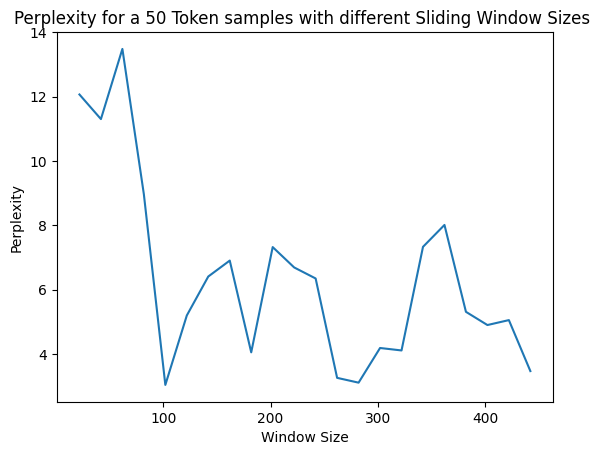

In [ ]:
plt.plot(windows[1:], p[1:])
plt.title('Perplexity for a 50 Token samples with different Sliding Window Sizes ')
plt.xlabel('Window Size')
plt.ylabel('Perplexity')
#plt.xticks(windows[1:])
plt.show()

Perplexity drops for higher window sizes as expected but there's still a lot of variation.

In [ ]:
#testing variation in tokens sample size with a set window size, what gives infinity?
tokens = range(2, 550, 20)
q = []
for t in tokens:
  q.append(perplexity(text, window = 100, tokens = t))

Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

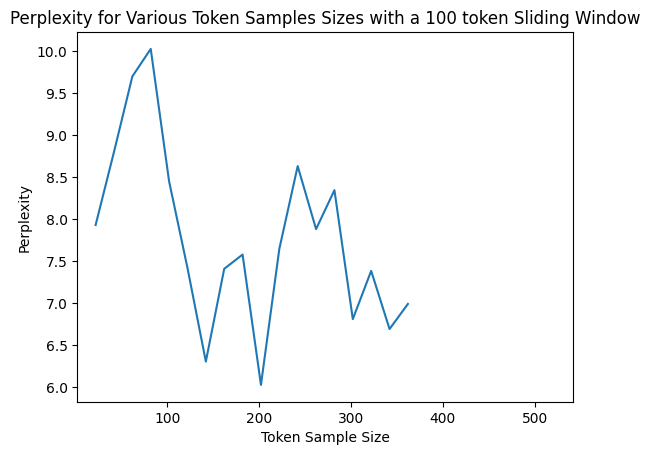

In [ ]:
plt.plot(tokens[1:], q[1:])
plt.title('Perplexity for Various Token Samples Sizes with a 100 token Sliding Window')
plt.xlabel('Token Sample Size')
plt.ylabel('Perplexity')
plt.xlim(min(tokens), max(tokens))
plt.show()

This provides an upper limit to the sample size of tokens than can be used to calculate perplexity. But small samples used to calculate perplexity for large pieces of text may have a large variation.

In [5]:
#read in real FTA text to test variation using less homogenous language
fta_text = open("UK-AU-FTA.txt").read()

In [ ]:
df = pd.DataFrame()
for j in range(10, 500, 50):
  ls = []
  for i in range(10):
    ls.append(perplexity(fta_text, tokens = 100, window = j))
  df['window ' + str(j)] = ls

Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

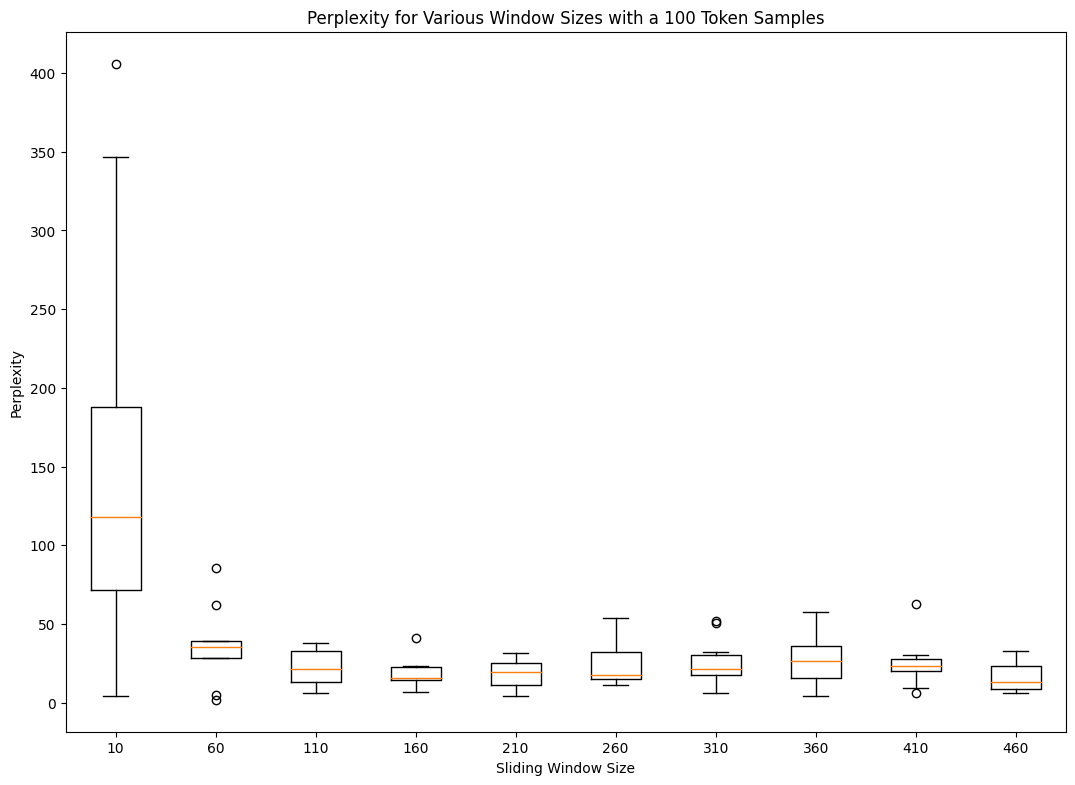

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(df)
ax.set_xticklabels(range(10, 500, 50))
plt.title('Perplexity for Various Window Sizes with a 100 Token Samples')
plt.xlabel('Sliding Window Size')
plt.ylabel('Perplexity')
plt.show()  

In addition to variation, this tells us that there is no significant improvement for window sizes beyond 160 tokens. We can therefore limit the amount of processing needed and only use a window of that size, rather than going up to the maximum of 1024.

In [ ]:
#check whether there's a difference in variation for different sample sizes of tokens
df = pd.DataFrame()
for j in range(5, 350, 50):
  ls = []
  for i in range(10):
    ls.append(perplexity(fta_text, tokens = j, window = 100))
  df['window ' + str(j)] = ls

Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum seq

In [ ]:
df

,window 5,window 55,window 105,window 155,window 205,window 255,window 305
0,29.770696,9.118796,20.432325,47.758197,22.324316,10.917174,inf
1,3.638225,37.816385,16.565267,13.926346,21.646723,inf,inf
2,2.409204,4.577743,36.420258,32.500578,inf,15.070553,inf
3,35.502247,46.117348,11.111330,21.790269,22.818650,14.673247,inf
4,5.247521,50.441793,22.697095,55.256384,29.706882,inf,inf
5,22.867562,43.412164,24.253619,21.559233,15.599105,inf,inf
6,102.863801,66.284124,21.599614,10.039905,16.296922,inf,inf
7,1.000258,10.282178,24.870661,14.940995,27.515688,inf,inf
8,304.006643,26.293137,22.582055,20.195533,29.929281,11.887353,inf
9,1.727008,28.912762,32.089849,22.534457,inf,3.889431,inf


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


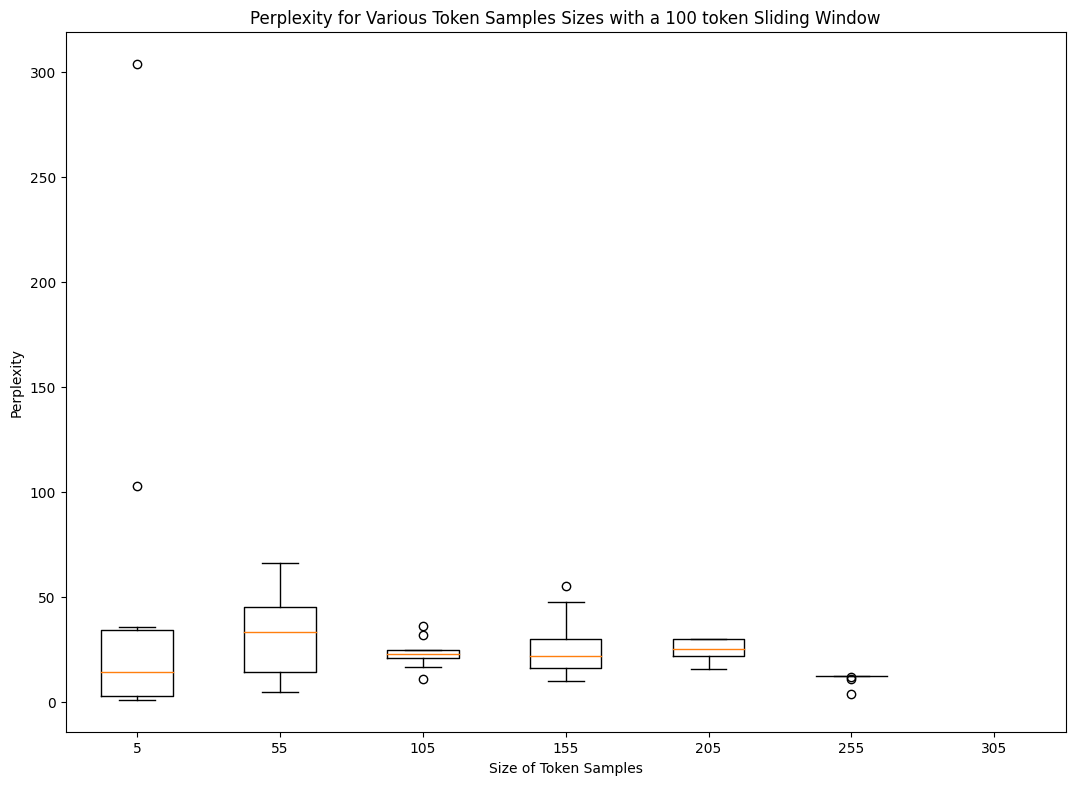

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(df)
ax.set_xticklabels(range(5, 350, 50))
plt.title('Perplexity for Various Token Samples Sizes with a 100 token Sliding Window')
plt.xlabel('Size of Token Samples')
plt.ylabel('Perplexity')
plt.show()  

In [4]:
#with this variation, we need to sample multiple times, re-writing the function to do that
def perplexity(text, model = 'facebook/bart-base', window = 110, tokens = 10, samples = 10):
  #read in chosen model and set up empty lists to use
  tokeniser = BartTokenizer.from_pretrained(model)
  model = BartForConditionalGeneration.from_pretrained(model)

  #tokenise text to get its length
  input_ids = tokeniser([text], return_tensors="pt")["input_ids"]
  n = len(input_ids[0])
  
  #check window is even number and is smaller than text length
  if window%2 != 0:
    raise ValueError("Window size must be even.")
  if window > n:
    raise ValueError("Window size must be shorter than the tokenised text.")
  #check number of tokens is smaller than text length
  if tokens > n:
    raise ValueError("Tokens length must be shorter than the tokenised text.")
  
  perplexities = []

  #run through each saample
  for j in range(samples):

    #set up empty lists/values
    prod__pp_t = 1

    #randomly select a set of tokens
    tokens_start = random.sample(range(0, n - tokens), 1)[0]
    tokens_end = tokens_start + tokens
  
    #iterate through tokens in this set
    for i in range(tokens_start, tokens_end):

      #find sliding window range for token
      a = int(i - (window/2))
      b = int(i + (window/2))
      if a < 0:
        b = b + abs(a)
        a = 0
      if b > n:
        a = a - (b - n)
        b = n

      #find real value of token then replace it with '<mask>' and slice to window
      input_ids_to_mask = copy.deepcopy(input_ids)
      true_token = int(input_ids_to_mask[0][i])
      input_ids_to_mask[0][i] = 50264
      input_ids_to_mask = input_ids_to_mask[:, a:b]

      #use BART to predict what this token is given the context in the window
      logits = model(input_ids_to_mask).logits
      masked_index = (input_ids_to_mask[0] == tokeniser.mask_token_id).nonzero().item()
      probs = logits[0, masked_index].softmax(dim=0)
      values, predictions = probs.topk(1000)
    
      #get the probability of the true token within this prediction
      try:
        true_token_index = predictions.tolist().index(true_token)
        true_token_prob = values[true_token_index].detach().numpy().item()
      #deal with words that aren't in the top 1000 predictions by assigning them a very small probability
      except:
        true_token_prob = 0.00001
    
      #calculate the reciprocals of the probabilities and multiple together
      pp_t = 1.0/true_token_prob
      prod__pp_t *= pp_t
  
    #calculate the perplexity by normalising this, also (for comparison) show avg probabilities
    perplexities.append(prod__pp_t ** (1.0/tokens))

  return perplexities

In [ ]:
#test this new fuction words as expected
perplexity(fta_text, tokens = 100, window = 500, samples = 5)

Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors


[15.491844367382363,
 24.82091674070604,
 56.563553545362254,
 20.789961310117643,
 26.143962788150283]

# Testing different fined-tuned BART models

In [6]:
#set seed so that results are repeated
np.random.seed(42)

In [8]:
#calculate different sets of perplexity
perplexities = pd.DataFrame()
perplexities['facebook/bart-large-mnli'] = perplexity(fta_text, model = 'facebook/bart-large-mnli')
perplexities['facebook/bart-large'] = perplexity(fta_text, model = 'facebook/bart-large')
perplexities['facebook/bart-large-cnn'] = perplexity(fta_text, model = 'facebook/bart-large-cnn')
perplexities['philschmid/bart-large-cnn-samsum'] = perplexity(fta_text, model = 'philschmid/bart-large-cnn-samsum')
perplexities['facebook/bart-base'] = perplexity(fta_text, model = 'facebook/bart-base')

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForConditionalGeneration: ['classification_head.out_proj.bias', 'classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (200017 > 1024). Running this sequence through the model will result in indexing errors


NameError: ignored